# Generate a set of data

The model is a bit more complicated. The bone is generated in similar way but the tooth is now rotated around one point on the tooth vertical axis such that it never compenetrates the bone.


In [1]:
import numpy as np

# Generator parameters

Here are some parameters that will be used for the generator

In [2]:
from typing import TypeVar

n = TypeVar("n", bound=int)


def generate_bone_and_tooth(count: n) -> np.ndarray[(n, 2, 4, 2), np.float32]:
    from second_util import ToothFactory
    tooth_factory = ToothFactory()
    return tooth_factory.generate_data_2d(count).reshape((-1, 2, 4, 2))

## Test single case generator

Let's test the gen

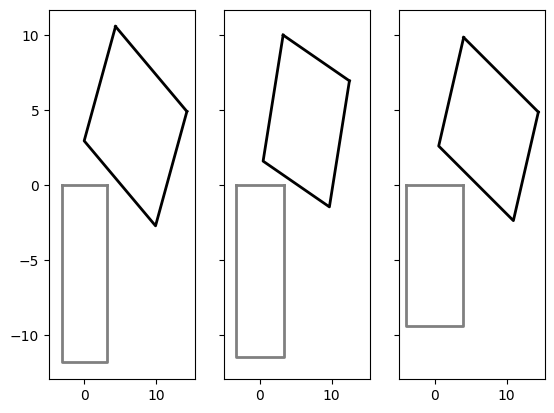

In [4]:

from utils import draw_square
import matplotlib.pyplot as plt

data = generate_bone_and_tooth(3)
f, axs = plt.subplots(1, len(data), sharey="row", sharex=True)

for (bn, tt), ax in zip(data, axs):
    #print("bone")
    #display(bn)
    #print("tooth")
    #display(tt)
    draw_square(ax, bn, color="grey")
    draw_square(ax, tt, color="black")

## Now create the dataset for the inputs

In [5]:
import pandas as pd

data = generate_bone_and_tooth(1000)



In [6]:
def save_input(data: np.ndarray, name="bone_tooth_v2.pkl") -> pd.DataFrame:
    from utils import datadir
    input_ds = pd.DataFrame(data=data.reshape(-1, 16),
                            index=pd.Index(range(data.shape[0]), dtype=np.int64, name="num"),
                            columns=["b0x", "b0y", "b1x", "b1y", "b2x", "b2y", "b3x", "b3y", "t0x",
                                     "t0y", "t1x", "t1y", "t2x", "t2y", "t3x", "t3y"])
    input_ds.to_pickle(datadir(name))
    return input_ds

## Now figure out a simple solution

We deduce a simple geometrical solution for the problem.

In [7]:
from utils import Implant_h, Implant_w


def solve_problem(bones_and_tooth: np.ndarray, implant_h=Implant_h,
                  implant_w=Implant_w) -> np.ndarray:
    bones = bones_and_tooth[:, 0, :].reshape(-1, 4, 2)
    tooth = bones_and_tooth[:, 1, :].reshape(-1, 4, 2)

    [B0, _B1, B2, B3] = [bones[:, i, :] for i in range(4)]
    [T0, T1, T2, T3] = [tooth[:, i, :] for i in range(4)]

    T_t = (T2 + T3) / 2

    T_b = (T0 + T1) / 2

    t = (B2[:, 1] - T_b[:, 1]) / (T_t[:, 1] - T_b[:, 1])
    t = t.reshape(-1, 1)

    # O = (B2 + B3) / 2

    O = T_t * t + (1 - t) * T_b

    O_max = B2[:, 0] - Implant_w / 2

    O = np.array([np.minimum(O[:, 0], O_max), O[:, 1]]).T

    r = np.sqrt(implant_h ** 2 + (implant_w ** 2) / 4)

    # (w/2,0)
    D = O - B3

    # (0,-h)
    C = B0 - B3

    #K = np.cross(C, D) / r

    # h w / 2r
    K = (C[:, 0] * D[:, 1] - C[:, 1] * D[:, 0]) / r

    # h
    U = np.sqrt(np.sum(C ** 2, axis=1))

    b0 = np.arctan2(implant_w / 2, implant_h)

    # w/2r
    cs = np.minimum(K / U, 1)
    sn = np.sqrt(1 - cs * cs)

    beta = np.arctan2(sn, cs)
    # -pi / 2
    gamma = np.arctan2(C[:, 1], C[:, 0])

    alpha_max = -(gamma + beta) - b0

    T_a = T_t - T_b

    #alpha_tooth = np.arctan2(T_a[:, 0], T_a[:, 1])

    tooth_center = (T0 + T1 + T2 + T3) / 4

    ideal_ax = tooth_center - O

    alpha_tooth = np.arctan2(ideal_ax[:, 0], ideal_ax[:, 1])

    alpha_ideal = np.array([alpha_tooth - n * np.pi / 36 for n in [0, 1, 2, 3, 4, 6]]).transpose(1,
                                                                                                 0)
    in_bound = alpha_ideal <= alpha_max.reshape(-1, 1)

    positive = alpha_ideal >= 0

    acceptable = in_bound & positive

    # Failsafe (last is always ok)
    acceptable[:, 5] = True

    min_ind = np.argmax(acceptable, axis=1)

    alpha_sel = np.array([alpha_ideal[i, acceptable[i]][0] for i in range(alpha_ideal.shape[0])])

    return np.array([alpha_sel, min_ind, alpha_max, O[:, 0], O[:, 1]]).T


sample = np.array([[[-8, -20, 8, -20, 8, 0, -8, 0], [-10, 0, 10, 0, 10, 10, -10, 10]]])
solve_problem(sample)


array([[0.        , 0.        , 0.70443669, 0.        , 0.        ]])

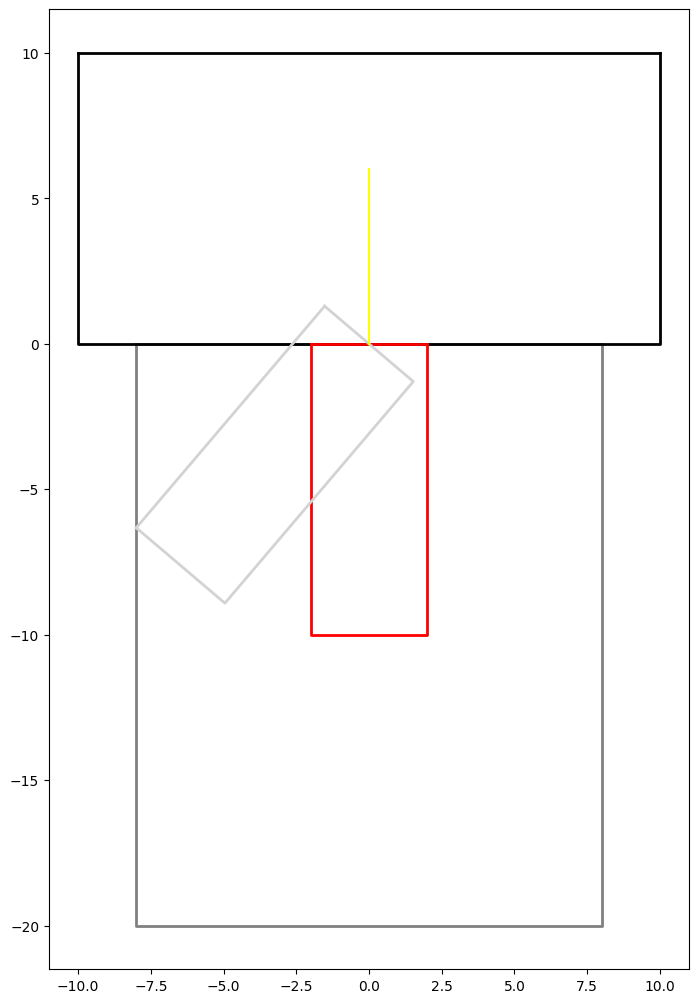

In [8]:

from utils import draw_solution

plt.figure()
draw_solution(plt.axes((0, 0, 1, 2)), sample[0], solve_problem(sample)[0])

In [9]:
output_data = solve_problem(data)
output_data

array([[ 1.13770024e-01,  0.00000000e+00,  1.81986493e-01,
         5.69196044e-01,  0.00000000e+00],
       [ 4.60174307e-02,  0.00000000e+00,  1.35566627e-01,
         6.38167428e-01, -1.11022302e-16],
       [ 8.71302237e-02,  0.00000000e+00,  2.80665599e-01,
         7.31589728e-01, -4.44089210e-16],
       ...,
       [ 5.39417771e-02,  0.00000000e+00,  2.69665407e-01,
         7.79195425e-01,  0.00000000e+00],
       [ 5.79042880e-02,  0.00000000e+00,  1.78648167e-01,
         6.74409768e-01,  4.44089210e-16],
       [ 8.73126144e-02,  0.00000000e+00,  2.28101727e-01,
         6.78484958e-01,  8.88178420e-16]])

## Now draw a couple of solutions, for check

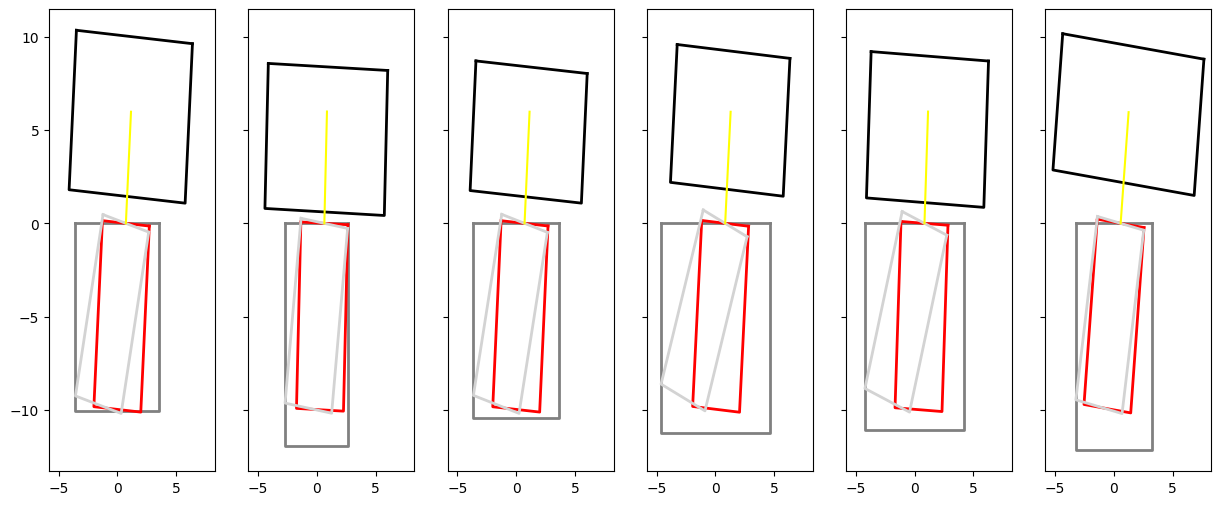

In [10]:
data_sample = [np.random.randint(0, len(data)) for k in range(6)]

f, axs = plt.subplots(1, len(data_sample), sharey="row", sharex=True, figsize=[15, 6])

for dt, ax in zip(data_sample, axs):
    row = data[dt]
    sol = output_data[dt]
    draw_solution(ax, row, sol)





## Let's add some more random-ness

Will translate input and outputs each by a random vector

In [11]:
from utils import rotation

final_input = []
final_out = []
MAX_THETA = np.pi / 3
t_list = []
for prob, sol in zip(data, output_data):
    thetas = (np.random.random() * 2 - 1) * MAX_THETA
    rots = rotation(thetas)
    tras = np.array([np.random.random() * 4 - 2, np.random.random() * 4 - 2])

    sig = 1 if np.random.random() >= 0.5 else -1
    flip = np.array([[sig, 0], [0, 1]])

    x = prob.reshape(-1, 2)
    x = np.matmul(np.matmul(x, flip), rots) + tras
    x = x.reshape(2, 8)

    final_input.append(x)

    [a, t, b, *O] = sol

    new_O = np.matmul(np.matmul(np.array(O), flip), rots) + tras

    final_out.append(np.array([a * sig + thetas, t, b * sig + thetas, *new_O]))

    t_list.append(np.array([*tras, thetas, sig]))

final_input = np.array(final_input)
final_out = np.array(final_out)
t_list = np.array(t_list)



## Draw the same sample some after scrambling

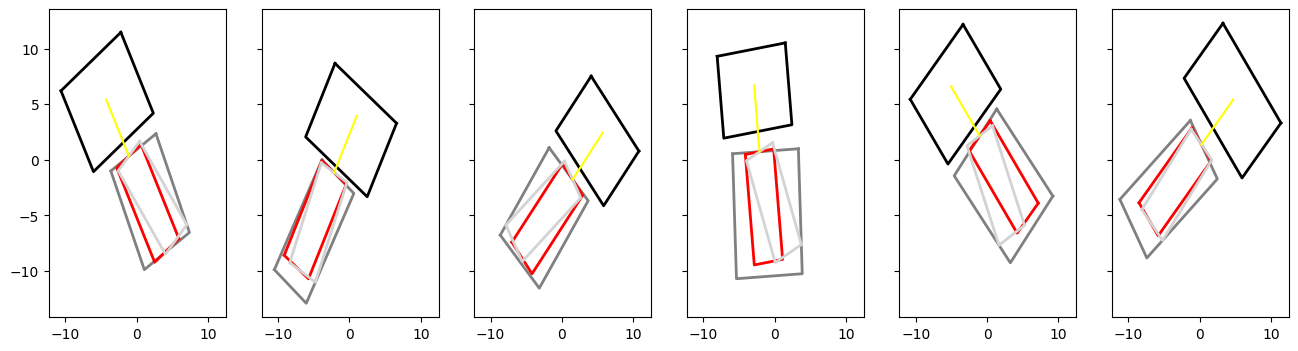

In [12]:
#data_sample = [np.random.randint(0, len(final_input)) for k in range(3)]

f, axs = plt.subplots(1, len(data_sample), sharey="row", sharex=True, figsize=[16, 4])

for dt, ax in zip(data_sample, axs):
    row = final_input[dt]
    sol = final_out[dt]
    draw_solution(ax, row, sol)


In [13]:
def save_output(data: np.ndarray, name="bone_tooth_v2_sol.pkl") -> pd.DataFrame:
    from utils import datadir
    input_ds = pd.DataFrame(data=data,
                            index=pd.Index(range(data.shape[0]), dtype=np.int64, name="num"),
                            columns=["alpha", "incl", "alpha_max", "Ox", "Oy"])
    input_ds.to_pickle(datadir(name))
    return input_ds


def save_trans(data: np.ndarray, name="bone_tooth_v2_sol_trans.pkl") -> pd.DataFrame:
    from utils import datadir
    input_ds = pd.DataFrame(data=data,
                            index=pd.Index(range(data.shape[0]), dtype=np.int64, name="num"),
                            columns=["tx", "ty", "theta", "flip"])
    input_ds.to_pickle(datadir(name))
    return input_ds

In [14]:
save_input(final_input)

,b0x,b0y,b1x,b1y,b2x,b2y,b3x,b3y,t0x,t0y,t1x,t1y,t2x,t2y,t3x,t3y
num,,,,,,,,,,,,,,,,
0,-6.955388,-9.472205,-1.206657,-12.319521,4.082423,-1.640867,-1.666308,1.206449,2.935137,10.471373,11.192583,5.136032,7.036799,-1.295826,-1.220646,4.039516
1,2.945172,-10.255480,8.026377,-8.457298,4.427626,1.711855,-0.653579,-0.086327,-5.238935,7.608160,5.264768,10.789761,7.520444,3.342897,-2.983259,0.161296
2,-1.736969,-11.357178,-8.516128,-7.261724,-3.352809,1.285060,3.426350,-2.810394,8.218835,5.192800,-1.564932,9.995349,-4.656270,3.697666,5.127497,-1.104883
3,-7.379645,-6.878206,-1.296608,-9.093096,2.088826,0.204753,-3.994211,2.419643,-0.332426,11.979317,8.187054,7.767093,4.796384,0.909257,-3.723095,5.121481
4,6.478595,-11.548735,10.380281,-7.592630,1.692688,0.975457,-2.208998,-2.980649,-8.811863,2.245854,-1.966468,8.644094,3.159003,3.160419,-3.686392,-3.237821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9.855391,-5.588060,5.591215,-10.531062,-3.376595,-2.794809,0.887581,2.148193,-4.627275,7.861437,-10.879952,-0.046022,-5.459730,-4.331962,0.792947,3.575496
996,8.408560,-2.888982,3.421828,-9.549833,-3.622036,-4.276353,1.364696,2.384498,-7.089955,7.593975,-12.225671,-0.243201,-5.324510,-4.765544,-0.188794,3.071632
997,6.835327,-8.412225,11.340077,-2.259880,3.193144,3.705308,-1.311606,-2.447036,-8.722845,2.630480,-1.944798,10.910974,3.934576,6.098378,-2.843471,-2.182116


In [15]:
save_output(final_out)

,alpha,incl,alpha_max,Ox,Oy
num,,,,,
0,0.573646,0.0,0.641863,1.718118,-0.469840
1,-0.294118,0.0,-0.204569,2.488630,1.025666
2,0.456316,0.0,0.262781,-0.589421,-0.384370
3,0.459176,0.0,0.535802,-0.404186,1.112482
4,-0.751647,0.0,-0.646391,0.201559,-0.536470
...,...,...,...,...,...
995,-0.901732,0.0,-1.062863,-1.714238,-0.867817
996,-0.990703,0.0,-1.239971,-1.614778,-1.595228
997,-0.884843,0.0,-0.669119,1.401094,1.257823


In [16]:
save_trans(t_list)

,tx,ty,theta,flip
num,,,,
0,1.208058,-0.217209,0.459876,1.0
1,1.887024,0.812764,-0.340135,1.0
2,0.036770,-0.762667,0.543446,-1.0
3,-0.952693,1.312198,0.349189,1.0
4,-0.258155,-1.002596,-0.792324,1.0
...,...,...,...,...
995,-1.244507,-0.323308,-0.858993,-1.0
996,-1.128670,-0.945927,-0.928152,-1.0
997,0.940769,0.629136,-0.938785,1.0


In [17]:
save_input(data, name="bone_tooth_v2_orig.pkl")

,b0x,b0y,b1x,b1y,b2x,b2y,b3x,b3y,t0x,t0y,t1x,t1y,t2x,t2y,t3x,t3y
num,,,,,,,,,,,,,,,,
0,-3.207612,-11.916711,3.207612,-11.916711,3.207612,0.0,-3.207612,0.0,-3.196341,10.344660,6.571240,9.228583,5.701909,1.620456,-4.065672,2.736534
1,-2.695000,-10.787154,2.695000,-10.787154,2.695000,0.0,-2.695000,0.0,-4.450667,8.783408,6.512704,8.278546,6.154769,0.505789,-4.808602,1.010652
2,-3.960105,-9.985357,3.960105,-9.985357,3.960105,0.0,-3.960105,0.0,-3.923782,9.328329,6.933800,8.379904,6.323311,1.391021,-4.534270,2.339446
3,-3.236861,-9.895007,3.236861,-9.895007,3.236861,0.0,-3.236861,0.0,-3.066767,10.235580,6.379719,9.192379,5.539984,1.588340,-3.906502,2.631541
4,-2.778215,-12.201901,2.778215,-12.201901,2.778215,0.0,-2.778215,0.0,-3.693498,8.371166,5.668751,7.990133,5.363515,0.490267,-3.998734,0.871300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-3.264064,-11.843615,3.264064,-11.843615,3.264064,0.0,-3.264064,0.0,-3.987742,7.907660,6.083919,7.476940,5.788679,0.573250,-4.282982,1.003970
996,-4.160361,-8.799183,4.160361,-8.799183,4.160361,0.0,-4.160361,0.0,-3.263621,9.890178,6.088054,9.304453,5.572283,1.069674,-3.779392,1.655399
997,-3.812614,-10.097326,3.812614,-10.097326,3.812614,0.0,-3.812614,0.0,-4.094199,8.979329,6.591101,8.402385,6.181455,0.815534,-4.503845,1.392478


In [18]:
save_output(output_data, name="bon_tooth_v2_sol_orig.pkl")

,alpha,incl,alpha_max,Ox,Oy
num,,,,,
0,0.113770,0.0,0.181986,0.569196,0.000000e+00
1,0.046017,0.0,0.135567,0.638167,-1.110223e-16
2,0.087130,0.0,0.280666,0.731590,-4.440892e-16
3,0.109987,0.0,0.186613,0.583735,0.000000e+00
4,0.040676,0.0,0.145933,0.654683,3.330669e-16
...,...,...,...,...,...
995,0.042740,0.0,0.203870,0.719123,6.661338e-16
996,0.062551,0.0,0.311820,0.811106,2.220446e-16
997,0.053942,0.0,0.269665,0.779195,0.000000e+00
